# 🚗 Used Car Price Prediction

Welcome! This notebook demonstrates a full machine learning workflow for predicting used car prices, including data exploration, preprocessing, modeling, evaluation, and interactive visualizations.

---

In [65]:
# Import libraries and set theme
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

In [66]:
# Data Loading
try:
    df = pd.read_csv('car_dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'car_dataset.csv' not found. Make sure the file is in the same directory.")
    exit()

Dataset loaded successfully!


In [67]:
# Initial Data Exploration
print("\n--- First 5 rows of the dataset ---")
print(df.head())
print("\n--- Dataset Info ---")
df.info()
print("\n--- Descriptive Statistics ---")
print(df.describe())
print("\n--- Missing Values Count ---")
print(df.isnull().sum())
print("\n--- Unique Values for Key Categorical Columns (Example Check) ---")
typical_categorical_cols = ['Brand', 'Model', 'Fuel Type', 'Transmission', 'Ownership', 'Color']
for col in typical_categorical_cols:
    if col in df.columns:
        print(f"\nUnique values in '{col}': {df[col].nunique()}")


--- First 5 rows of the dataset ---
   make_year  mileage_kmpl  engine_cc fuel_type  owner_count  price_usd  \
0       2001          8.17       4000    Petrol            4    8587.64   
1       2014         17.59       1500    Petrol            4    5943.50   
2       2023         18.09       2500    Diesel            5    9273.58   
3       2009         11.28        800    Petrol            1    6836.24   
4       2005         12.23       1000    Petrol            2    4625.79   

       brand transmission  color service_history  accidents_reported  \
0  Chevrolet       Manual  White             NaN                   0   
1      Honda       Manual  Black             NaN                   0   
2        BMW    Automatic  Black            Full                   1   
3    Hyundai       Manual   Blue            Full                   0   
4     Nissan    Automatic    Red            Full                   0   

  insurance_valid  
0              No  
1             Yes  
2             Yes  

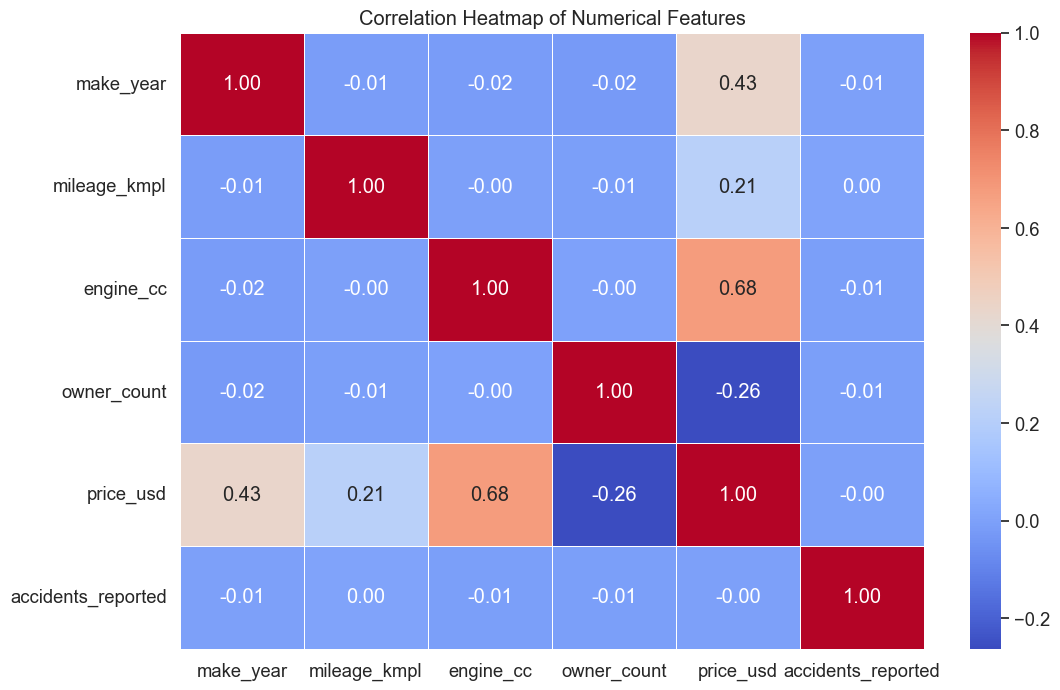

In [68]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

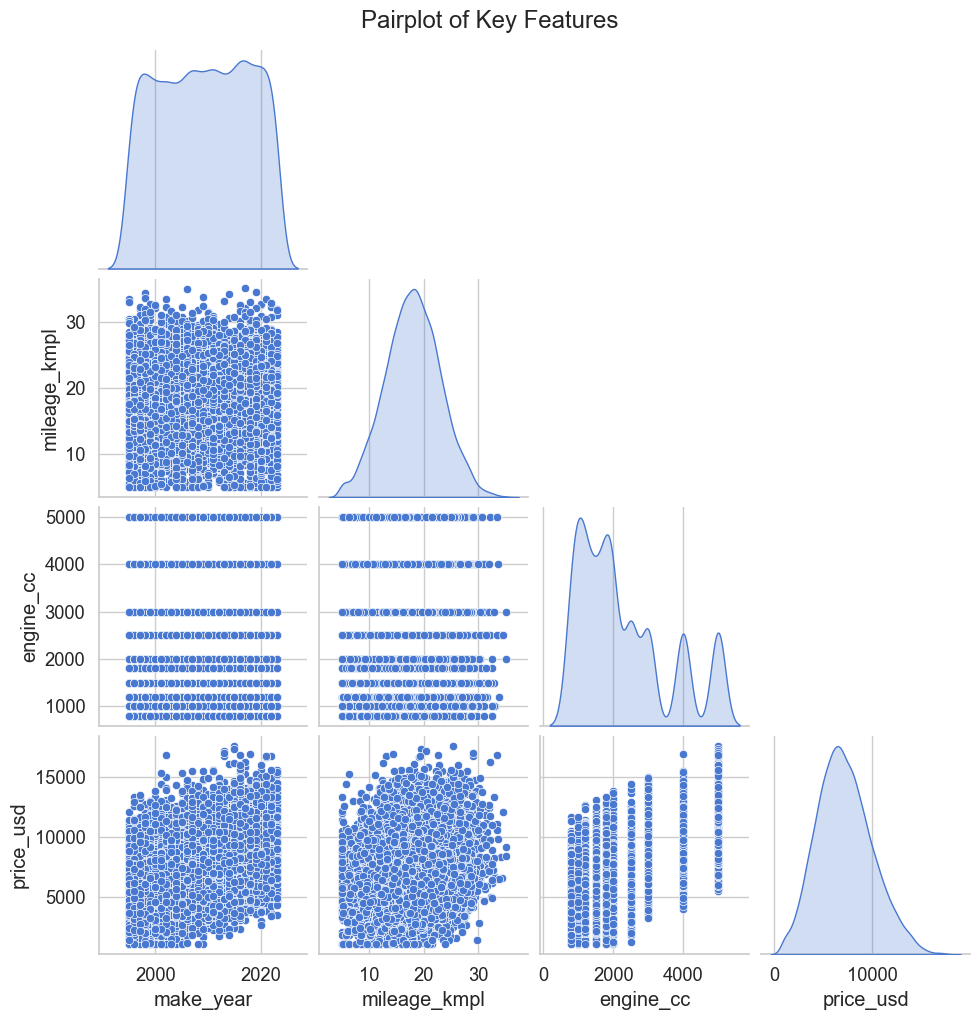

In [69]:
# Pairplot of Key Features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'price_usd' in numerical_features:
    numerical_features.remove('price_usd')
key_features = numerical_features[:3] + ['price_usd'] if len(numerical_features) >= 3 else numerical_features + ['price_usd']
sns.pairplot(df[key_features], diag_kind="kde", corner=True)
plt.suptitle("Pairplot of Key Features", y=1.02)
plt.show()

In [70]:
# Data Preprocessing
print("\n--- Starting Data Preprocessing ---")
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print("Dropped 'Unnamed: 0' column.")
numerical_cols_to_impute = ['Engine Size', 'Max Power', 'Torque']
categorical_cols_to_impute = ['Fuel Type', 'Transmission']
for col in numerical_cols_to_impute:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing values in '{col}' with median: {median_val}")
for col in categorical_cols_to_impute:
    if col in df.columns and df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)
        print(f"Filled missing values in '{col}' with mode: {mode_val}")
print("\n--- Missing Values After Handling ---")
print(df.isnull().sum())
if 'Year' in df.columns:
    current_year = pd.Timestamp.now().year
    df['Car_Age'] = current_year - df['Year']
    df.drop('Year', axis=1, inplace=True)
    print("\n'Car_Age' feature created and 'Year' column dropped.")
    print(df[['Car_Age', 'price_usd']].head())
else:
    print("\n'Year' column not found for 'Car_Age' feature engineering.")
categorical_features = ['fuel_type', 'brand', 'transmission', 'color', 'service_history', 'insurance_valid']
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'price_usd' in numerical_features:
    numerical_features.remove('price_usd')
categorical_features_present = [col for col in categorical_features if col in df.columns]
numerical_features_present = [col for col in numerical_features if col in df.columns]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_present),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_present)
    ],
    remainder='passthrough'
)
print(f"\nDefined numerical features for scaling: {numerical_features_present}")
print(f"Defined categorical features for encoding: {categorical_features_present}")
print("\n--- Data Preprocessing Complete (defined via ColumnTransformer) ---")


--- Starting Data Preprocessing ---

--- Missing Values After Handling ---
make_year                0
mileage_kmpl             0
engine_cc                0
fuel_type                0
owner_count              0
price_usd                0
brand                    0
transmission             0
color                    0
service_history       2038
accidents_reported       0
insurance_valid          0
dtype: int64

'Year' column not found for 'Car_Age' feature engineering.

Defined numerical features for scaling: ['make_year', 'mileage_kmpl', 'engine_cc', 'owner_count', 'accidents_reported']
Defined categorical features for encoding: ['fuel_type', 'brand', 'transmission', 'color', 'service_history', 'insurance_valid']

--- Data Preprocessing Complete (defined via ColumnTransformer) ---


In [71]:
# Model Selection, Training & Evaluation
print("\n--- Starting Model Training & Evaluation ---")
X = df.drop('price_usd', axis=1)
y = df['price_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nData split: X_train:{X_train.shape}, X_test:{X_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
def evaluate_model(model_name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {model_name} Evaluation ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R-squared: {r2:.4f}")
    return mae, rmse, r2
print("\n--- Training Linear Regression Model ---")
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
mae_lr, rmse_lr, r2_lr = evaluate_model("Linear Regression", y_test, y_pred_lr)
print("\n--- Training Decision Tree Regressor Model ---")
pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', DecisionTreeRegressor(random_state=42))])
pipeline_dt.fit(X_train, y_train)
y_pred_dt = pipeline_dt.predict(X_test)
mae_dt, rmse_dt, r2_dt = evaluate_model("Decision Tree Regressor", y_test, y_pred_dt)
print("\n--- Training Neural Network (MLPRegressor) Model ---")
pipeline_mlp = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42, early_stopping=True, n_iter_no_change=20))])
pipeline_mlp.fit(X_train, y_train)
y_pred_mlp = pipeline_mlp.predict(X_test)
mae_mlp, rmse_mlp, r2_mlp = evaluate_model("Neural Network (MLPRegressor)", y_test, y_pred_mlp)
print("\n--- Hyperparameter Tuning for Decision Tree Regressor using GridSearchCV ---")
param_grid_dt = {
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_dt.fit(X_train, y_train)
print(f"\nBest parameters for Decision Tree: {grid_search_dt.best_params_}")
print(f"Best cross-validation score (negative MSE): {grid_search_dt.best_score_:.2f}")
best_dt_model = grid_search_dt.best_estimator_
y_pred_dt_tuned = best_dt_model.predict(X_test)
mae_dt_tuned, rmse_dt_tuned, r2_dt_tuned = evaluate_model("Tuned Decision Tree Regressor", y_test, y_pred_dt_tuned)


--- Starting Model Training & Evaluation ---

Data split: X_train:(8000, 11), X_test:(2000, 11), y_train:(8000,), y_test:(2000,)

--- Training Linear Regression Model ---

--- Linear Regression Evaluation ---
MAE: 791.00
RMSE: 991.02
R-squared: 0.8765

--- Training Decision Tree Regressor Model ---

--- Decision Tree Regressor Evaluation ---
MAE: 1227.99
RMSE: 1534.02
R-squared: 0.7042

--- Training Neural Network (MLPRegressor) Model ---

--- Neural Network (MLPRegressor) Evaluation ---
MAE: 790.69
RMSE: 990.65
R-squared: 0.8766

--- Hyperparameter Tuning for Decision Tree Regressor using GridSearchCV ---
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters for Decision Tree: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10}
Best cross-validation score (negative MSE): -1523910.10

--- Tuned Decision Tree Regressor Evaluation ---
MAE: 964.14
RMSE: 1214.24
R-squared: 0.8147



--- Visualizing Performance for Tuned Decision Tree Regressor ---


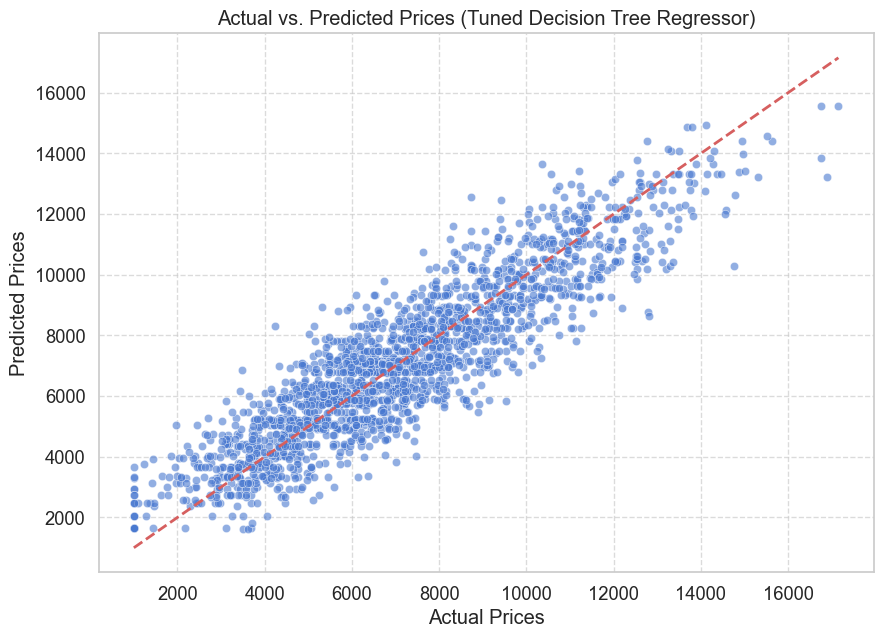

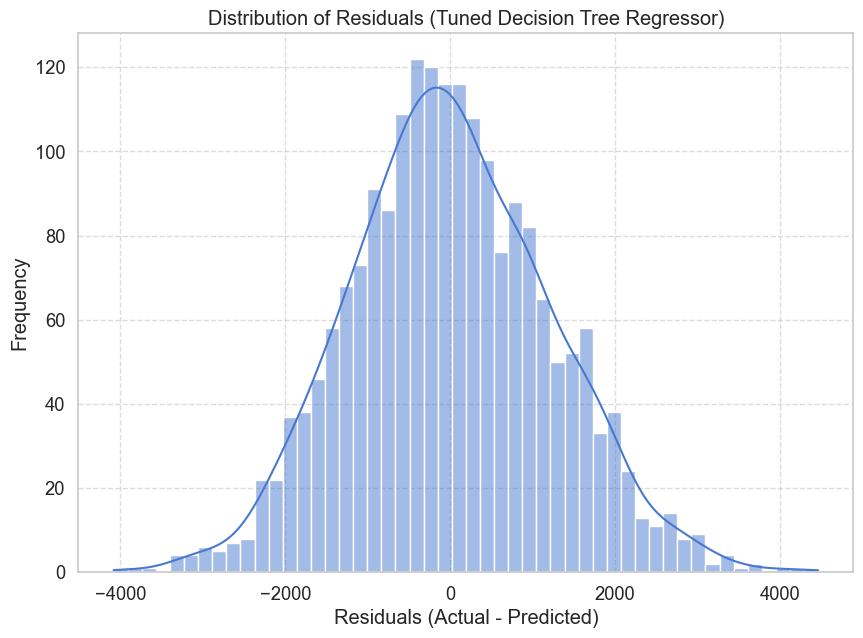

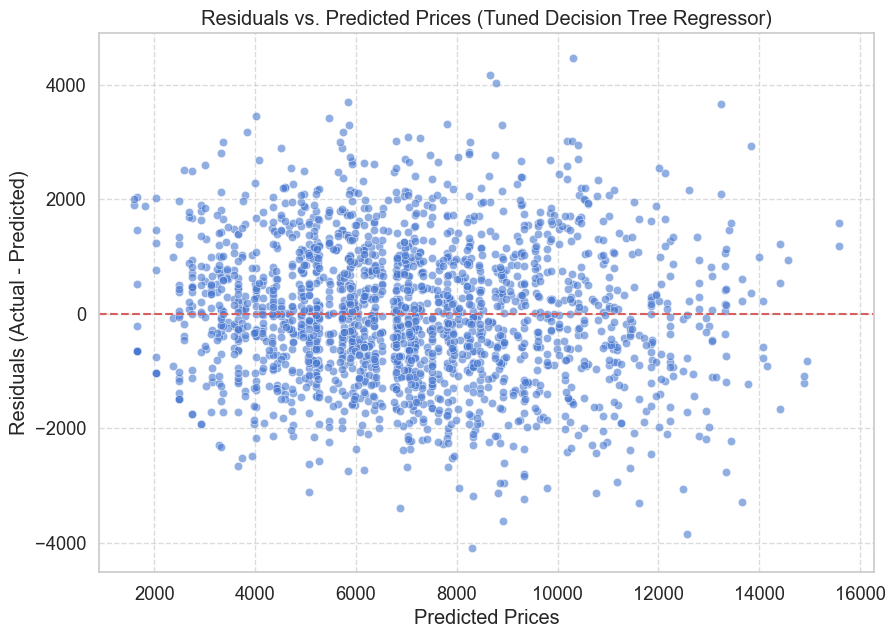

In [72]:
# Model Analysis and Visualization
y_preds_best_model = y_pred_dt_tuned
best_model_name = "Tuned Decision Tree Regressor"
print(f"\n--- Visualizing Performance for {best_model_name} ---")
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_preds_best_model, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title(f"Actual vs. Predicted Prices ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
residuals = y_test - y_preds_best_model
plt.figure(figsize=(10, 7))
sns.histplot(residuals, kde=True, bins=50)
plt.title(f"Distribution of Residuals ({best_model_name})")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_preds_best_model, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Prices")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residuals vs. Predicted Prices ({best_model_name})")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


--- Extracting Feature Importances ---

--- Top 10 Feature Importances ---
                         Feature  Importance
2                 num__engine_cc    0.511624
0                 num__make_year    0.224256
6        cat__fuel_type_Electric    0.119315
3               num__owner_count    0.070382
1              num__mileage_kmpl    0.062615
26     cat__service_history_Full    0.001282
4        num__accidents_reported    0.001155
27  cat__service_history_Partial    0.001095
28      cat__service_history_nan    0.000977
23                cat__color_Red    0.000873


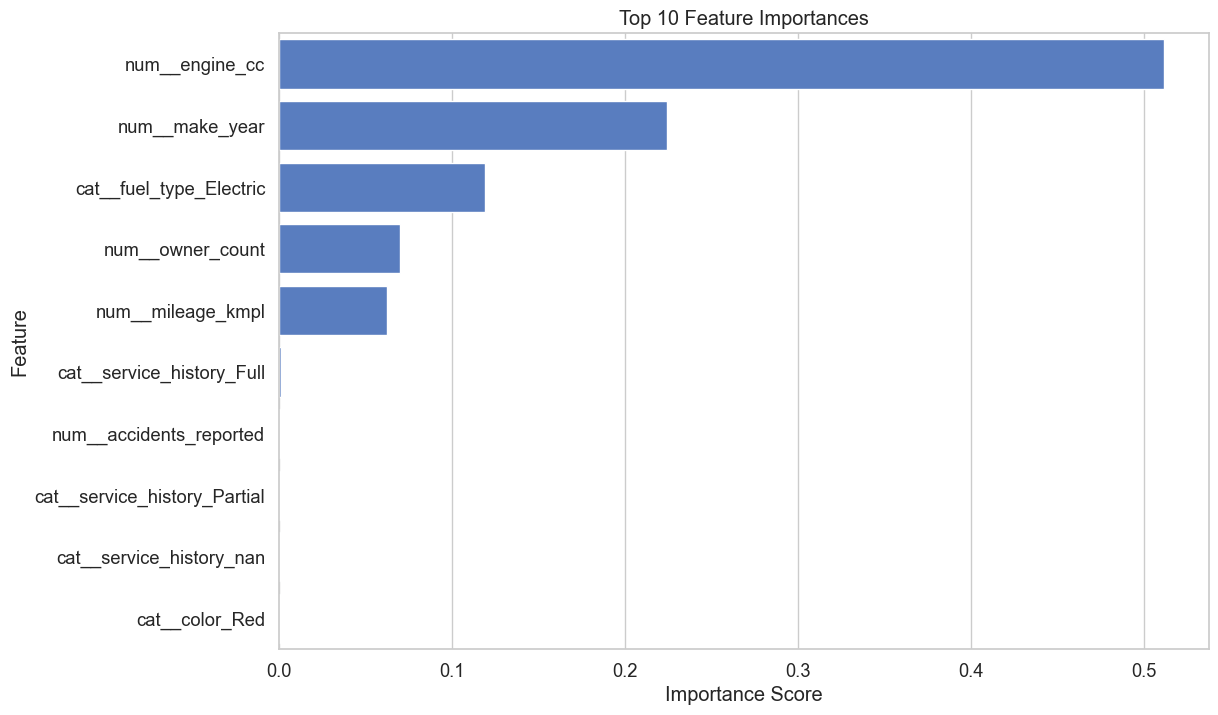

In [73]:
# --- Feature Importance (for Tree-based models like Decision Tree) ---
if hasattr(best_dt_model.named_steps['regressor'], 'feature_importances_'):
    print("\n--- Extracting Feature Importances ---")
    # Try to get feature names from the preprocessor
    try:
        if hasattr(best_dt_model.named_steps['preprocessor'], 'get_feature_names_out'):
            all_feature_names_transformed = best_dt_model.named_steps['preprocessor'].get_feature_names_out()
        else:
            numerical_ftrs = best_dt_model.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()
            categorical_ftrs = []
            if hasattr(best_dt_model.named_steps['preprocessor'].named_transformers_['cat'], 'get_feature_names_out'):
                categorical_ftrs = best_dt_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()
            all_feature_names_transformed = list(numerical_ftrs) + list(categorical_ftrs)
    except Exception as e:
        print(f"Could not extract feature names: {e}")
        all_feature_names_transformed = [f"feature_{i}" for i in range(len(best_dt_model.named_steps['regressor'].feature_importances_))]

    feature_importances = best_dt_model.named_steps['regressor'].feature_importances_
    if len(all_feature_names_transformed) != len(feature_importances):
        print(f"Warning: Feature names ({len(all_feature_names_transformed)}) and importances ({len(feature_importances)}) length mismatch. Using generic names.")
        all_feature_names_transformed = [f"feature_{i}" for i in range(len(feature_importances))]

    importance_df = pd.DataFrame({'Feature': all_feature_names_transformed, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 10 Feature Importances ---")
    print(importance_df.head(10))

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()
else:
    print(f"\nFeature importances are not directly available for {best_model_name} in this manner.")
    print("Consider advanced techniques like Permutation Importance or SHAP values for model-agnostic explanations.")

In [74]:
# Improved Interactive Prediction Widget
import ipywidgets as widgets
from IPython.display import display, Markdown

def predict_price_interactive(model, feature_columns):
    inputs = {}
    for col in feature_columns:
        if df[col].dtype == 'object':
            options = [opt for opt in df[col].dropna().unique().tolist() if pd.notnull(opt)]
            if not options:
                options = ['N/A']
            inputs[col] = widgets.Dropdown(options=options, value=options[0], description=col)
        else:
            min_val = float(df[col].min())
            max_val = float(df[col].max())
            mean_val = float(df[col].mean())
            inputs[col] = widgets.FloatSlider(value=mean_val, min=min_val, max=max_val, step=1.0, description=col)
    button = widgets.Button(description="Predict Price", button_style='success')
    output = widgets.Output()

    def on_button_clicked(b):
        input_data = {col: [inputs[col].value] for col in feature_columns}
        input_df = pd.DataFrame(input_data)
        pred = model.predict(input_df)[0]
        with output:
            output.clear_output()
            display(Markdown(f"### 💰 Predicted Price: **${pred:,.2f}**"))

    button.on_click(on_button_clicked)
    display(*(inputs.values()), button, output)

predict_price_interactive(best_dt_model, X.columns)

FloatSlider(value=2009.2069, description='make_year', max=2023.0, min=1995.0, step=1.0)

FloatSlider(value=17.960753, description='mileage_kmpl', max=35.0, min=5.0, step=1.0)

FloatSlider(value=2287.13, description='engine_cc', max=5000.0, min=800.0, step=1.0)

Dropdown(description='fuel_type', options=('Petrol', 'Diesel', 'Electric'), value='Petrol')

FloatSlider(value=3.0035, description='owner_count', max=5.0, min=1.0, step=1.0)

Dropdown(description='brand', options=('Chevrolet', 'Honda', 'BMW', 'Hyundai', 'Nissan', 'Tesla', 'Toyota', 'K…

Dropdown(description='transmission', options=('Manual', 'Automatic'), value='Manual')

Dropdown(description='color', options=('White', 'Black', 'Blue', 'Red', 'Gray', 'Silver'), value='White')

Dropdown(description='service_history', options=('Full', 'Partial'), value='Full')

FloatSlider(value=0.4922, description='accidents_reported', max=5.0, step=1.0)

Dropdown(description='insurance_valid', options=('No', 'Yes'), value='No')

Button(button_style='success', description='Predict Price', style=ButtonStyle())

Output()

---

## 🎉 Thank you for exploring this notebook!

Feel free to experiment with the interactive widgets above, try different models, or visualize new insights.  
Happy Predicting! 🚗💨